In [45]:
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc, f1_score, ConfusionMatrixDisplay
from transformers import AutoTokenizer, AutoModel, get_scheduler

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

from langchain_ollama.llms import OllamaLLM
from langchain_core.prompts import PromptTemplate
from langchain.chains import LLMChain

import matplotlib.pyplot as plt
import numpy as np

# Acceso a archivos
import sys
import os

import pickle
import pandas as pd

In [47]:
#FUNCIONES PERSONALIZADAS PARA LOS MODELOS
sys.path.append(os.path.abspath("../funciones"))

#IMPORAR FUNCIONES AUXILIARES PERSONALIZADAS DESDE EL MÓDULO
from funcionesEntrenamiento import (
    reporte_clasificacion,
    crear_matriz_confusion,
    calcular_roc_auc,
    metricas_tpr_fpr,
)

from funcionesEntrenamientoEnsamble import (
    parametros_4_oof,
    predicciones_de_modelos,
    test_ensamble
)

#IMPORAR FUNCIONES AUXILIARES PERSONALIZADAS DESDE EL MÓDULO
from funcionesEntrenamientoLLM import (
    cargar_datos_entrenamiento,
    imprimir_forma,
    obtener_predicciones,
    reporte_clasificacion,
    crear_matriz_confusion,
    calcular_roc_auc,
    metricas_tpr_fpr,
)

In [3]:
# Tokenization
tokenizer = AutoTokenizer.from_pretrained("PlanTL-GOB-ES/roberta-base-bne")

class TweetDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=128)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.labels)

In [4]:
class RobertaClassifier(nn.Module):
    def __init__(self, unfreeze_layers=None):
        super().__init__()
        self.bert = AutoModel.from_pretrained("PlanTL-GOB-ES/roberta-base-bne")
        for name, param in self.bert.named_parameters():
            param.requires_grad = False
            
        if unfreeze_layers:
            for name, param in self.bert.named_parameters():
                if any(layer in name for layer in unfreeze_layers):
                    param.requires_grad = True

        self.dropout = nn.Dropout(0.5)
        self.intermediate = nn.Linear(self.bert.config.hidden_size, 128)
        self.relu = nn.ReLU()
        self.classifier = nn.Linear(128, 1)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = torch.mean(outputs.last_hidden_state, dim=1) # CLS token = outputs.last_hidden_state[:, 0, :] 
        x = self.dropout(x)
        x = self.relu(self.intermediate(x))
        x = self.classifier(x)
        return x.squeeze(-1)

In [5]:
print("Cargando modelos entrenados...\n")
model_path = os.path.abspath("../../models")

with open(os.path.join(model_path, 'modelMLP.pkl'), 'rb') as file:
    modelMLP = pickle.load(file)
    print("Modelo MLP cargado en una variable.")

with open(os.path.join(model_path, 'modelPAC.pkl'), 'rb') as file:
    modelPAC = pickle.load(file)
    print("Modelo PAC cargado en una variable.")

with open(os.path.join(model_path, 'modelRF.pkl'), 'rb') as file:
    modelRF = pickle.load(file)
    print("Modelo RF cargado en una variable.")

with open(os.path.join(model_path, 'modelSVM.pkl'), 'rb') as file:
    modelSVM = pickle.load(file)
    print("Modelo SVM cargado en una variable.")

with open(os.path.join(model_path, 'modelXGB.pkl'), 'rb') as file:
    modelXGB = pickle.load(file)
    print("Modelo XGB cargado en una variable.")

with open(os.path.join(model_path, 'metaModelEns.pkl'), 'rb') as file:
    metaModel = pickle.load(file)
    print("Metamodelo cargado en una variable.")

path_ROBERTA = os.path.join(model_path, 'final_best_model.pt')
bestModelROBERTA = RobertaClassifier()
bestModelROBERTA.load_state_dict(torch.load(path_ROBERTA, map_location=torch.device('cpu')))

Cargando modelos entrenados...

Modelo MLP cargado en una variable.
Modelo PAC cargado en una variable.
Modelo RF cargado en una variable.
Modelo SVM cargado en una variable.
Modelo XGB cargado en una variable.
Metamodelo cargado en una variable.


Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

model.safetensors:  67%|######7   | 336M/499M [00:00<?, ?B/s]

c:\Users\saaso\miniconda3\envs\ia-env\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\saaso\.cache\huggingface\hub\models--PlanTL-GOB-ES--roberta-base-bne. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [6]:
print("Cargando datos para modelos numéricos...")
df = pd.read_csv("../../data/ds_tradicional_TEST_FINAL.csv", encoding="utf-8", header=0)

print(df.shape)
df.head(5)

Cargando datos para modelos numéricos...
(250, 1569)


,longitud_texto,num_palabras,comida,restriccion,purga,imagen_corporal,ejercicio,polaridad,subjetividad,tag_Anorexia,...,tfidf_1491,tfidf_1492,tfidf_1493,tfidf_1494,tfidf_1495,tfidf_1496,tfidf_1497,tfidf_1498,tfidf_1499,class
0,-0.483373,-0.283019,0,0,0,0,0,0.486894,0.753341,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,2.315037,2.366144,0,1,0,1,1,-0.194929,0.542246,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,1.382234,1.703853,0,1,0,0,0,0.798344,0.405655,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,-1.295814,-1.166073,0,0,0,0,0,0.259620,-0.538062,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,-0.874548,-0.724546,2,2,0,0,0,-0.346445,-1.134095,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [7]:
print("Cargando datos para modelo BERT...")
df_BERT = pd.read_csv("../../data/ds_BETO_TEST_FINAL.csv", encoding="utf-8", header=0)

print(df_BERT.shape)
df_BERT.head(5)

Cargando datos para modelo BERT...
(250, 2)


,texto_bert,class
0,no es malo ayunar 20 dias al mes ... ya que no...,1
1,"¡7 días, 7 razones para entrenar! - llegamos a...",0
2,"de avena, banana (o plátano) y cacao súper san...",0
3,cuanto pesan ustedes yo 29,1
4,como bajar peso comiendo sin parar.. Etiquetas...,1


In [50]:
print("Cargando datos para LLM...")
df_LLM = pd.read_csv("../../data/data_test_fold2.csv", encoding="utf-8", header=0)

print(df_LLM.shape)
df_LLM.head(5)

Cargando datos para LLM...
(250, 4)


,user_id,tweet_id,tweet_text,class
0,user1502,c1a446a05987,no es malo ayunar 20 dias al mes ... ya que no...,anorexia
1,user1503,bfdce07b546c,"¡7 días, 7 razones para entrenar!\n-\nLlegamos...",control
2,user1504,860a2eced012,"#Cookies de avena, banana (o plátano) y cacao ...",control
3,user1505,b745c4311c24,cuanto pesan ustedes\nyo 29,anorexia
4,user1506,fdcb32f44ce7,Como bajar peso comiendo sin parar.\n #Tips,anorexia


In [8]:
X = df.drop(columns=['class'])
y = df['class']

In [9]:
X_BERT = df_BERT['texto_bert'].tolist()
y_BERT = df_BERT['class'].tolist()

dataset_BERT = TweetDataset(X_BERT, y_BERT)
loader_BERT = DataLoader(dataset_BERT, batch_size=16)

In [51]:
X_LLM = df_LLM['tweet_text']
y_LLM = df_LLM["class"].map({'control': 0, 'anorexia': 1})

In [10]:
#CREACIÓN DEL REPORTE DE CLASIFICACIÓN
y_pred_MLP, y_proba_MLP, reporte_MLP = reporte_clasificacion(X, y, modelMLP)

print("Classification Report:")
print(reporte_MLP)

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       116
           1       0.89      0.93      0.91       134

    accuracy                           0.90       250
   macro avg       0.90      0.90      0.90       250
weighted avg       0.90      0.90      0.90       250



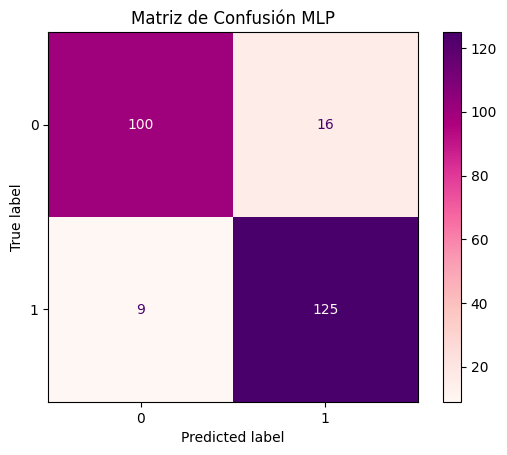

In [11]:
# Matriz de confusión
cm_MLP, disp_MLP = crear_matriz_confusion(y, y_pred_MLP)
disp_MLP.plot(cmap='RdPu')
plt.title("Matriz de Confusión MLP")
plt.show()

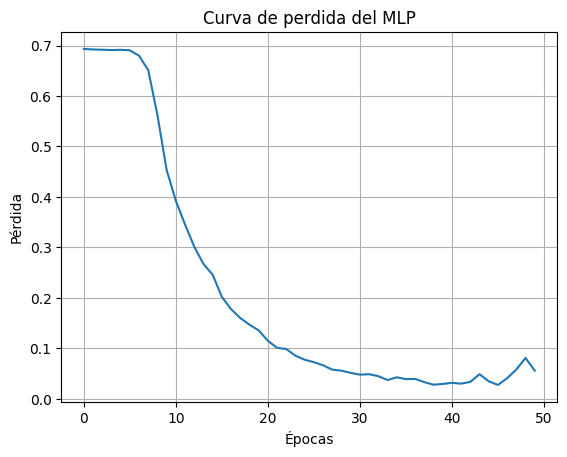

In [12]:
#CURVA DE PERDIDA DEL MLP
plt.plot(modelMLP.loss_curve_)
plt.title("Curva de perdida del MLP")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.grid(True)
plt.show()

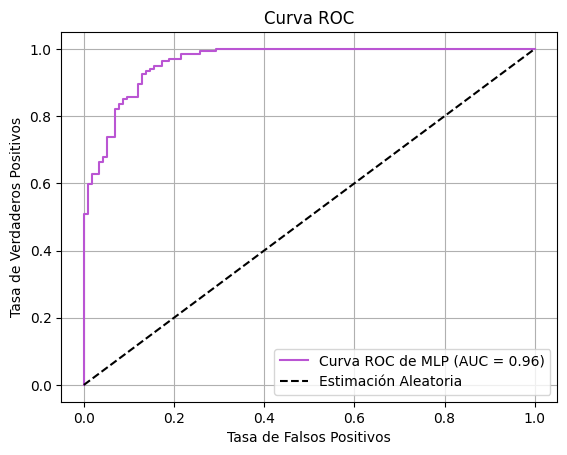

In [13]:
# Predicciones de probabilidad (para curva ROC)
fpr_MLP, tpr_MLP, thresholds_MLP, auc_score_MLP = calcular_roc_auc(y, y_proba_MLP)

# Gráfica ROC
plt.figure()
plt.plot(fpr_MLP, tpr_MLP, color='mediumorchid', label=f"Curva ROC de MLP (AUC = {auc_score_MLP:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Estimación Aleatoria")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [14]:
# Cálculo de métricas de desempeño de la matriz de confusión
TPR_MLP, FPR_MLP = metricas_tpr_fpr(cm_MLP)

# Mostrar métricas
print(f"AUC: {(auc_score_MLP * 100):.4f}")
print(f"TPR (True Positive Rate): {(TPR_MLP * 100):.4f}")
print(f"FPR (False Positive Rate): {(FPR_MLP * 100):.4f}")

AUC: 96.1915
TPR (True Positive Rate): 93.2836
FPR (False Positive Rate): 13.7931


In [15]:
#CREACIÓN DEL REPORTE DE CLASIFICACIÓN
y_pred_RF, y_proba_RF, reporte_RF = reporte_clasificacion(X, y, modelRF)

print("Classification Report:")
print(reporte_RF)

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.77      0.84       116
           1       0.83      0.96      0.89       134

    accuracy                           0.87       250
   macro avg       0.88      0.86      0.86       250
weighted avg       0.88      0.87      0.87       250



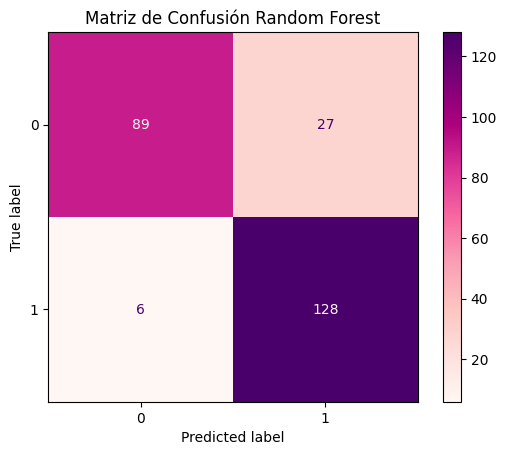

In [16]:
# Matriz de confusión
cm_RF, disp_RF = crear_matriz_confusion(y, y_pred_RF)
disp_RF.plot(cmap='RdPu')
plt.title("Matriz de Confusión Random Forest")
plt.show()

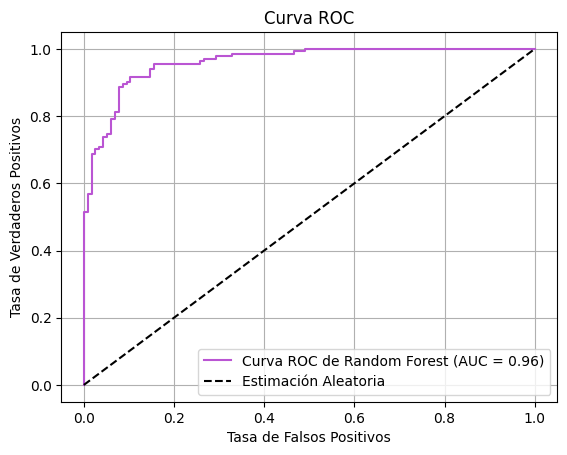

In [17]:
# Predicciones de probabilidad (para curva ROC)
fpr_RF, tpr_RF, thresholds_RF, auc_score_RF = calcular_roc_auc(y, y_proba_RF)

# Gráfica ROC
plt.figure()
plt.plot(fpr_RF, tpr_RF, color='mediumorchid', label=f"Curva ROC de Random Forest (AUC = {auc_score_RF:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Estimación Aleatoria")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [18]:
# Cálculo de métricas de desempeño de la matriz de confusión
TPR_RF, FPR_RF = metricas_tpr_fpr(cm_RF)

# Mostrar métricas
print(f"AUC: {(auc_score_RF * 100):.4f}")
print(f"TPR (True Positive Rate): {(TPR_RF * 100):.4f}")
print(f"FPR (False Positive Rate): {(FPR_RF * 100):.4f}")

AUC: 96.0950
TPR (True Positive Rate): 95.5224
FPR (False Positive Rate): 23.2759


In [19]:
#CREACIÓN DEL REPORTE DE CLASIFICACIÓN
y_pred_PAC, y_proba_PAC, reporte_PAC = reporte_clasificacion(X, y, modelPAC, True)

print("Classification Report:")
print(reporte_PAC)

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.84      0.87       116
           1       0.87      0.93      0.90       134

    accuracy                           0.88       250
   macro avg       0.89      0.88      0.88       250
weighted avg       0.89      0.88      0.88       250



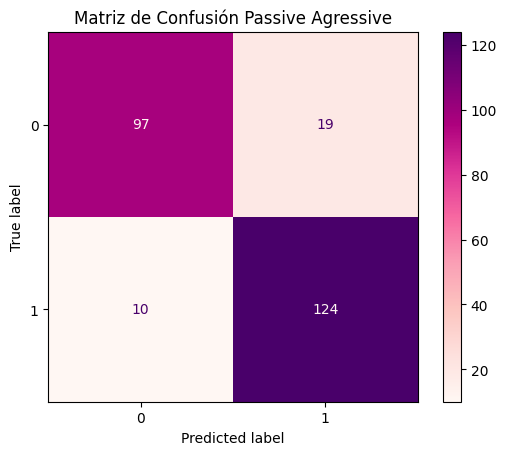

In [20]:
# Matriz de confusión
cm_PAC, disp_PAC = crear_matriz_confusion(y, y_pred_PAC)
disp_PAC.plot(cmap='RdPu')
plt.title("Matriz de Confusión Passive Agressive")
plt.show()

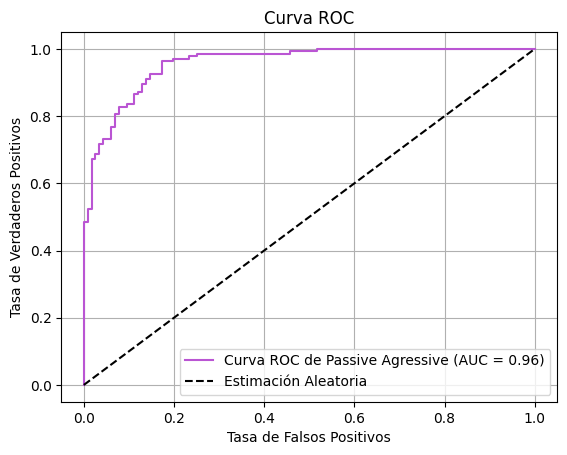

In [21]:
# Predicciones de probabilidad (para curva ROC)
fpr_PAC, tpr_PAC, thresholds_PAC, auc_score_PAC = calcular_roc_auc(y, y_proba_PAC)

# Gráfica ROC
plt.figure()
plt.plot(fpr_PAC, tpr_PAC, color='mediumorchid', label=f"Curva ROC de Passive Agressive (AUC = {auc_score_PAC:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Estimación Aleatoria")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [22]:
# Cálculo de métricas de desempeño de la matriz de confusión
TPR_PAC, FPR_PAC = metricas_tpr_fpr(cm_PAC)

# Mostrar métricas
print(f"AUC: {(auc_score_PAC * 100):.4f}")
print(f"TPR (True Positive Rate): {(TPR_PAC * 100):.4f}")
print(f"FPR (False Positive Rate): {(FPR_PAC * 100):.4f}")

AUC: 95.7604
TPR (True Positive Rate): 92.5373
FPR (False Positive Rate): 16.3793


In [23]:
#CREACIÓN DEL REPORTE DE CLASIFICACIÓN
y_pred_SVM, y_proba_SVM, reporte_SVM = reporte_clasificacion(X, y, modelSVM)

print("Classification Report:")
print(reporte_SVM)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.84      0.90       116
           1       0.87      0.98      0.92       134

    accuracy                           0.91       250
   macro avg       0.92      0.91      0.91       250
weighted avg       0.92      0.91      0.91       250



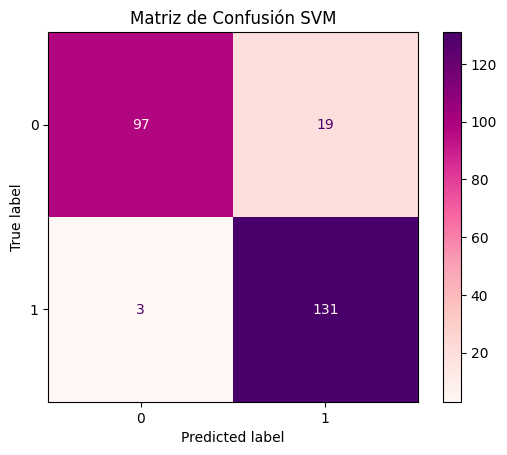

In [24]:
# Matriz de confusión
cm_SVM, disp_SVM = crear_matriz_confusion(y, y_pred_SVM)
disp_SVM.plot(cmap='RdPu')
plt.title("Matriz de Confusión SVM")
plt.show()

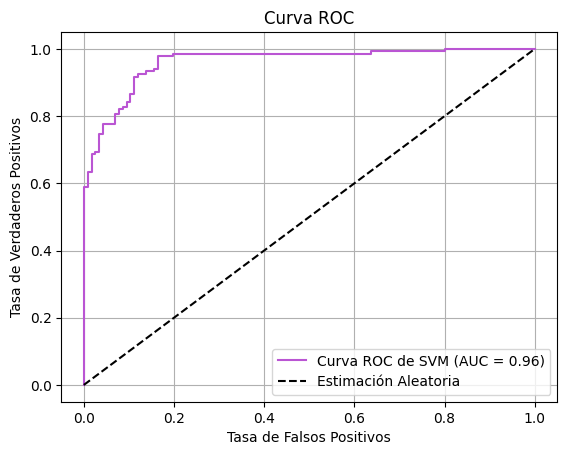

In [25]:
# Predicciones de probabilidad (para curva ROC)
fpr_SVM, tpr_SVM, thresholds_SVM, auc_score_SVM = calcular_roc_auc(y, y_proba_SVM)

# Gráfica ROC
plt.figure()
plt.plot(fpr_SVM, tpr_SVM, color='mediumorchid', label=f"Curva ROC de SVM (AUC = {auc_score_SVM:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Estimación Aleatoria")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [26]:
# Cálculo de métricas de desempeño de la matriz de confusión
TPR_SVM, FPR_SVM = metricas_tpr_fpr(cm_SVM)

# Mostrar métricas
print(f"AUC: {(auc_score_SVM * 100):.4f}")
print(f"TPR (True Positive Rate): {(TPR_SVM * 100):.4f}")
print(f"FPR (False Positive Rate): {(FPR_SVM * 100):.4f}")

AUC: 96.0564
TPR (True Positive Rate): 97.7612
FPR (False Positive Rate): 16.3793


In [27]:
#CREACIÓN DEL REPORTE DE CLASIFICACIÓN
y_pred_XGB, y_proba_XGB, reporte_XGB = reporte_clasificacion(X, y, modelXGB)

print("Classification Report:")
print(reporte_XGB)

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.77      0.80       116
           1       0.81      0.87      0.84       134

    accuracy                           0.82       250
   macro avg       0.83      0.82      0.82       250
weighted avg       0.83      0.82      0.82       250



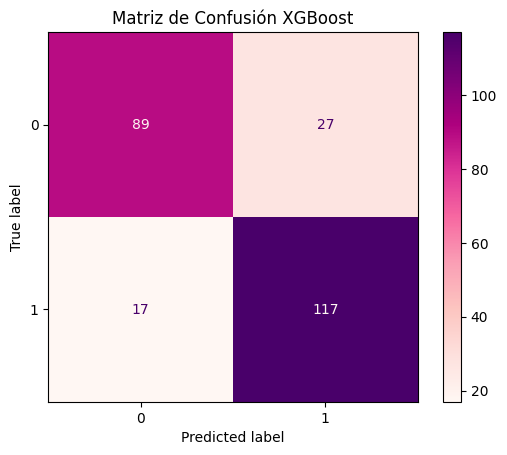

In [28]:
# Matriz de confusión
cm_XGB, disp_XGB = crear_matriz_confusion(y, y_pred_XGB)
disp_XGB.plot(cmap='RdPu')
plt.title("Matriz de Confusión XGBoost")
plt.show()

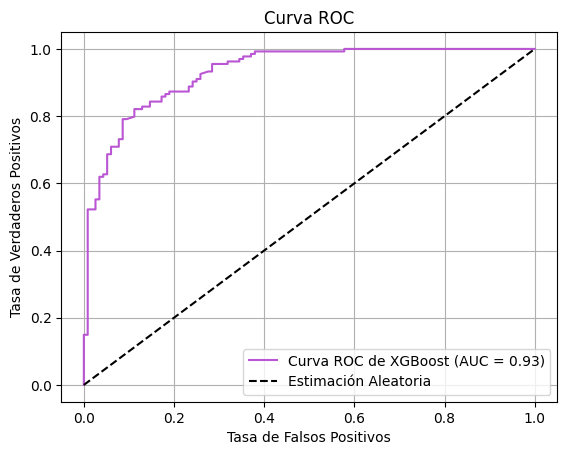

In [29]:
# Predicciones de probabilidad (para curva ROC)
fpr_XGB, tpr_XGB, thresholds_XGB, auc_score_XGB = calcular_roc_auc(y, y_proba_XGB)

# Gráfica ROC
plt.figure()
plt.plot(fpr_XGB, tpr_XGB, color='mediumorchid', label=f"Curva ROC de XGBoost (AUC = {auc_score_XGB:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Estimación Aleatoria")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [30]:
# Cálculo de métricas de desempeño de la matriz de confusión
TPR_XGB, FPR_XGB = metricas_tpr_fpr(cm_XGB)

# Mostrar métricas
print(f"AUC: {(auc_score_XGB * 100):.4f}")
print(f"TPR (True Positive Rate): {(TPR_XGB * 100):.4f}")
print(f"FPR (False Positive Rate): {(FPR_XGB * 100):.4f}")

AUC: 93.1613
TPR (True Positive Rate): 87.3134
FPR (False Positive Rate): 23.2759


In [31]:
X_meta = test_ensamble(X)

In [32]:
y_pred_ensamble, y_proba_ensamble, reporte_ensamble = reporte_clasificacion(X_meta, y, metaModel)

print("Classification Report:")
print(reporte_ensamble)

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89       116
           1       0.88      0.94      0.91       134

    accuracy                           0.90       250
   macro avg       0.90      0.90      0.90       250
weighted avg       0.90      0.90      0.90       250



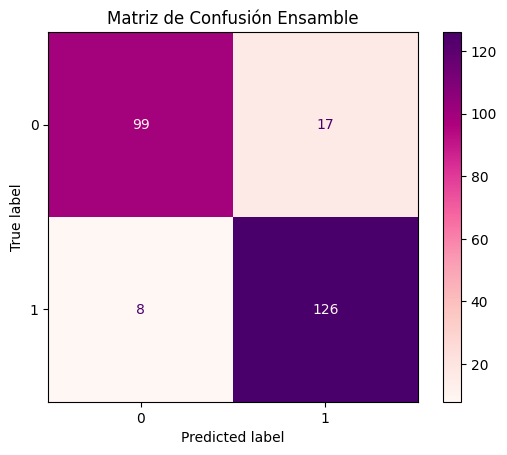

In [33]:
# Matriz de confusión
cm_ensamble, disp_ensamble = crear_matriz_confusion(y, y_pred_ensamble)
disp_ensamble.plot(cmap='RdPu')
plt.title("Matriz de Confusión Ensamble")
plt.show()

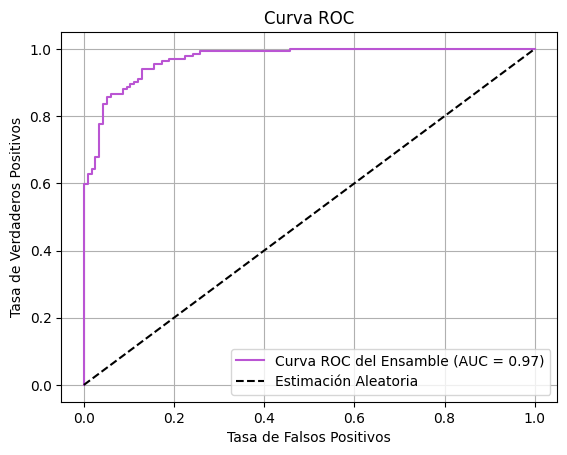

In [34]:
# Predicciones de probabilidad (para curva ROC)
fpr_ensamble, tpr_ensamble, thresholds_ensamble, auc_score_ensamble = calcular_roc_auc(y, y_proba_ensamble)

# Gráfica ROC
plt.figure()
plt.plot(fpr_ensamble, tpr_ensamble, color='mediumorchid', label=f"Curva ROC del Ensamble (AUC = {auc_score_ensamble:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Estimación Aleatoria")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [35]:
# Cálculo de métricas de desempeño de la matriz de confusión
TPR_ensamble, FPR_ensamble = metricas_tpr_fpr(cm_ensamble)

# Mostrar métricas
print(f"AUC: {(auc_score_ensamble * 100):.4f}")
print(f"TPR (True Positive Rate): {(TPR_ensamble * 100):.4f}")
print(f"FPR (False Positive Rate): {(FPR_ensamble * 100):.4f}")

AUC: 96.8798
TPR (True Positive Rate): 94.0299
FPR (False Positive Rate): 14.6552


In [36]:
bestModelROBERTA.eval()

RobertaClassifier(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50262, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): 

In [40]:
y_verdaderas, y_probs = [], []

with torch.no_grad():
    for batch in loader_BERT:
        input_ids = batch["input_ids"].to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        attention_mask = batch["attention_mask"].to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        labels = batch["labels"].cpu().numpy()

        outputs = bestModelROBERTA(input_ids, attention_mask)
        probs = torch.sigmoid(outputs).cpu().numpy()

        y_probs.extend(probs)
        y_verdaderas.extend(labels)

y_true = np.array(y_verdaderas)
y_probs = np.array(y_probs)
y_pred = (y_probs >= 0.5).astype(int)

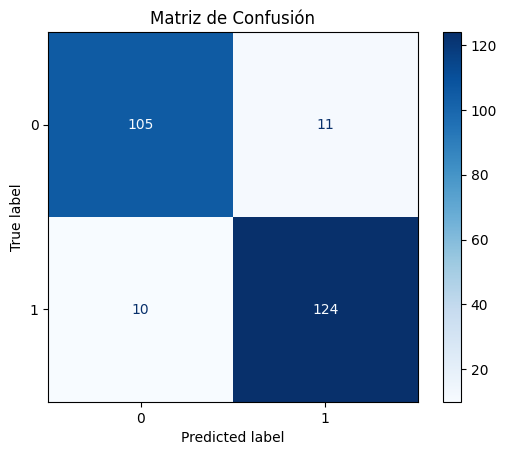

In [ ]:
auc_score = roc_auc_score(y_true, y_probs)
f1 = f1_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fpr, tpr, tresholds = roc_curve(y_true, y_probs)

disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión BERT")
plt.grid(False)
plt.show()

AUC: 0.9626
F1 Score: 0.9219


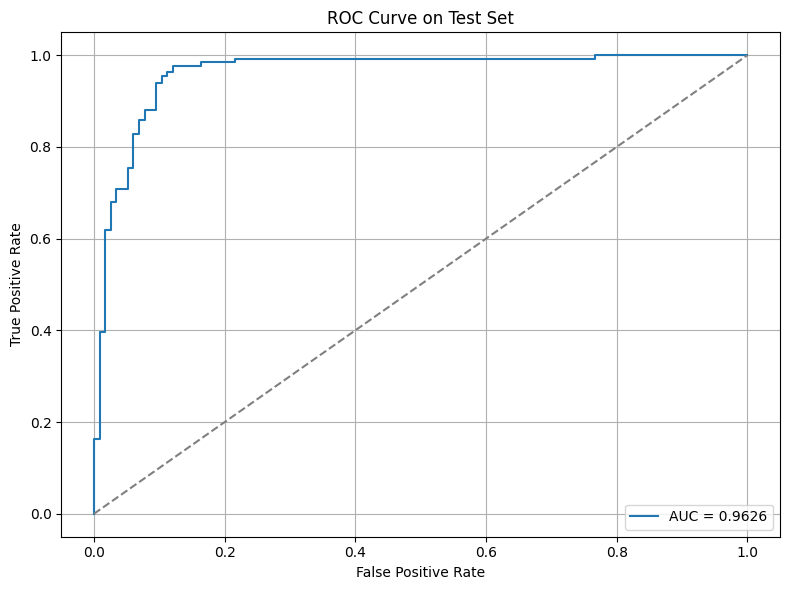

In [44]:
print(f"AUC: {auc_score:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on Test Set")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("roc_curve_test_set.png")
plt.show()

In [52]:
# Inicializar modelo LLaMA3 vía Ollama
llm = OllamaLLM(model="llama3")

In [53]:
# Crear el prompt con few-shot
prompt = PromptTemplate.from_template("""
Eres un asistente experto en salud mental. Tu tarea es analizar tweets e indicar si muestran señales de un posible trastorno alimenticio (como anorexia, bulimia, o similares).

Responde únicamente con "Sí" si el tweet indica un posible trastorno alimenticio, y con "No" si no lo indica.

Ejemplos:
Tweet: "no comí en todo el día y me siento bien" → Sí
Tweet: "me encanta comer con mis amigos los fines de semana" → No
Tweet: "me siento gorda incluso si no como nada" → Sí
Tweet: "hoy hice ejercicio y luego almorcé con mi familia" → No
Tweet: "ser como ellas ♡♡
  #hastaLoshuesos" → Sí
Tweet: "hoy #domingo os esperamos desde las 10:00 de la mañana para empezar el día con un buen desayuno.

también podéis reservar mesa para comer o cenar y disfrutar de nuestra carta o del menú fin de semana.
 980 56 99 34

#felizdomingo #restaurantealabros #zamora  #yum" → No

Ahora, clasifica el siguiente tweet, recuerda responder únicamente con dos letras en cada caso 'Sí' o 'No', sin explicaciones, como se muestra en los ejemplos. También recuerda que lo que recibes como input es únicamente el tweet y nada más que el tweet al que tienes que clasificar:
Tweet: "{tweet}" → 
""")

In [54]:
# Crear el pipeline
chain = LLMChain(prompt=prompt, llm=llm)

C:\Users\saaso\AppData\Local\Temp\ipykernel_9532\3755763389.py:2: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  chain = LLMChain(prompt=prompt, llm=llm)


In [58]:
# Obtener predicciones
predicciones_LLM = obtener_predicciones(chain, X_LLM)

Clasificando tweets con LLaMA3: 100%|██████████| 250/250 [00:38<00:00,  6.46it/s]


In [59]:
y_preds_LLM, reporte_LLAMA = reporte_clasificacion(predicciones_LLM, y_LLM)

print("Classification Report:")
print(reporte_LLAMA)

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.57      0.71       116
           1       0.72      0.97      0.83       134

    accuracy                           0.78       250
   macro avg       0.83      0.77      0.77       250
weighted avg       0.82      0.78      0.77       250



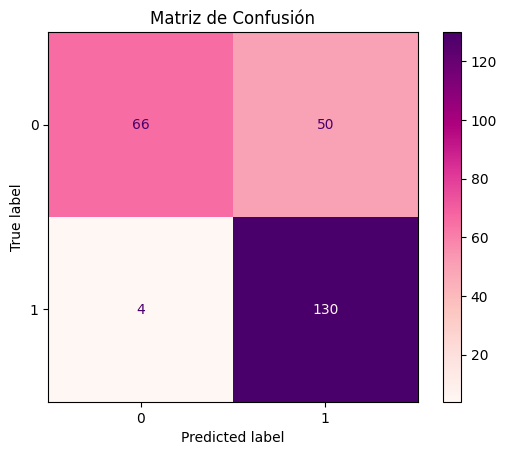

In [63]:
cm_LLM, disp_LLM = crear_matriz_confusion(y_LLM, y_preds_LLM)

disp_LLM.plot(cmap='RdPu')
plt.title("Matriz de Confusión")
plt.show()

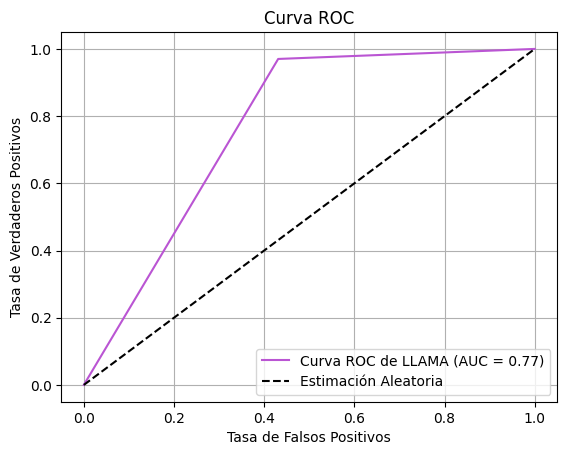

In [64]:
#CURVA ROC
fpr_LLM, tpr_LLM, thresholds_LLM, auc_score_LLM = calcular_roc_auc(y_LLM, y_preds_LLM)

plt.figure()
plt.plot(fpr_LLM, tpr_LLM, color='mediumorchid', label=f"Curva ROC de LLAMA (AUC = {auc_score_LLM:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Estimación Aleatoria")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [65]:
#MÉTRICAS TPR/FPR
TPR_LLM, FPR_LLM = metricas_tpr_fpr(cm_LLM)

# Mostrar métricas
print(f"AUC: {(auc_score_LLM * 100):.4f}")
print(f"TPR (Tasa de Positivos Verdaderos): {(TPR_LLM * 100):.4f}")
print(f"FPR (Tasa de Falsos Positivos): {(FPR_LLM * 100):.4f}")

AUC: 76.9557
TPR (Tasa de Positivos Verdaderos): 97.0149
FPR (Tasa de Falsos Positivos): 43.1034
